## Connect to workspace

Create a workspace object from the existing workspace. Workspace.from_config() reads the file config.json and loads the details into an object named ws.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Initialize a workspace object from persisted configuration.
import azureml.core
from azureml.core import Workspace

# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

st-project	westus2	st-project
Azure ML SDK Version:  1.39.0


## Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments.


Experiment is a logical container in an Azure ML Workspace. It hosts run records which can include run metrics and output artifacts from your experiments.

In [2]:
experiment_name = 'EefficientNet-NSFW'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

## Create or Attach existing compute resource

By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

    Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist. 

Creation of compute takes approximately 5 minutes. If the AmlCompute with that name is already in your workspace the code will skip the creation process.


In [3]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=6)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2022-04-09T07:19:53.997000+00:00', 'errors': None, 'creationTime': '2022-04-09T07:19:36.487856+00:00', 'modifiedTime': '2022-04-09T07:19:55.349465+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


You now have the necessary packages and compute resources to train a model in the cloud.
## Download the NSFW dataset

In [4]:
# 需要 1.0.72 版或更新版本的 azureml-core
from azureml.core import Workspace, Dataset

subscription_id = 'b2b0aec4-fb37-46e7-be9e-705aecda2746'
resource_group = 'st-project'
workspace_name = 'st-project'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='nsfw-train-val-dataset')
dataset.download(target_path='.', overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/training-on-gpu/code/Users/stancode.gpb2/HuaJung-training-job/train/nsfw/000b4e02-e495-4626-9d05-c3fb57d75ef8.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/training-on-gpu/code/Users/stancode.gpb2/HuaJung-training-job/train/nsfw/00a0b573-2600-424c-8f06-29e38a76f42a.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/training-on-gpu/code/Users/stancode.gpb2/HuaJung-training-job/train/nsfw/00ab993c-f8da-4552-b51d-b788da88bb68.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/training-on-gpu/code/Users/stancode.gpb2/HuaJung-training-job/train/nsfw/00e0190b-5508-4966-96ff-609a2ffae7f1.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/training-on-gpu/code/Users/stancode.gpb2/HuaJung-training-job/train/nsfw/00e90eb6-da82-42fe-afe1-16138d4d1deb.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/training-on-gpu/code/Users/stancode.gpb2/HuaJung-training-job/train/nsfw/00f26452-fde8-48ac-a2cd-4b240f6d5b8b.jpg',
 '/m

In [5]:
import torch
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as T

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
transform = T.Compose([T.Resize((256, 256)),
#                        T.FiveCrop(100),
                    #    T.ColorJitter(brightness=.8, hue=.5),
                       T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                    #    T.RandomResizedCrop(32),
                       T.RandomHorizontalFlip(p=0.5),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                      ])

- train: 4310 pcs
- val: 1818 pcs


In [7]:
train = dset.ImageFolder('train/', transform=transform)
val = dset.ImageFolder('val/', transform=transform)
classes = train.class_to_idx
print(classes)

{'nsfw': 0, 'sfw': 1}


In [8]:
mini_trains = DataLoader(train, batch_size=10, shuffle=True, num_workers=1)
mini_vals = DataLoader(val, batch_size=10, shuffle=True, num_workers=1)

## Display Some Images

In [9]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
classes_labels = list(classes)

def denormalize(image):
    image = T.Normalize(-0.0456/0.224, 1/0.224)(image)
    image = image.permute(1, 2, 0)
    image = torch.clamp(image, 0, 1)
    return image

def imshow(img):
    img = denormalize(img)
    plt.imshow(img)
    
dataiter = iter(mini_trains)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding lables
fig = plt.figure(figsize=(25, 8))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}".format(classes_labels[labels[idx]]))

IndexError: index 10 is out of bounds for dimension 0 with size 10

In [10]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU

import torch

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


## Create Training Process

In [11]:
def train(model, optimizer, epochs=1):
    model.train()
    loss_history = []
    train_acc = 0

    for e in range(epochs):
        print('----------------------------------')
        print(f'TRAIN EPOCH: {e + 1}')
        for idx, (x, y) in enumerate(mini_trains):
            x = x.to(device)
            y = y.to(device)
            
            # clean previous graident param
            optimizer.zero_grad()
            
            # forwardpass
            scores = model(x)

            # count total loss for CrossEntropy
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(scores, y)
            loss_history.append(loss.item()*x.size(0))

            # calcuate accuracy
            prediction = scores.data.max(1)[1]
            acc = prediction.eq(y).sum().item()
            train_acc += acc

            # backbward prop
            loss.backward()
            
            # update param
            optimizer.step()
            
            if idx % 7 == 0:
                # print(f'Iteration:{idx}, loss = {loss.item():.4f}')
                print('{}/{} ({:.0f}%)\tTraining Loss: {:.6f}\tTraining Acc: {:.3f}%'
                .format(idx * len(x), len(mini_trains.dataset),
                100. * idx / len(mini_trains), loss.item(),
                100. * train_acc / (len(mini_trains.dataset)*(e+1))))

                # len(mini_trains):batch-size/訓練集總量的整數數量 eg. 64/2000約等於32
                # len(min_trains.dataset):訓練集總量 eg. 2000
                # idx:迭代batch-size/總量的整數數量 eg. 0~31
        print(f'Training Accuarcy: {100. * train_acc / (len(mini_trains.dataset)*(e+1)):.3f}%')
        eval_or_test(model, mini_vals)

    # plot loss diagram
    loss_x = list((range(len(loss_history))))
    loss_y = loss_history
    plt.plot(loss_x, loss_y)
    plt.title('Training Loss Over Time', color = 'blue', fontsize=20)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

## Create Evaluating / Testing Process

In [12]:
def eval_or_test(model, eval_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    error_1 = 0
    error_2 = 0
    corr = 0

    # Pass gradient caculation
    with torch.no_grad():
        for x, y in eval_loader:
            # move tensors to GPU if CUDA is available
            x = x.to(device)
            y = y.to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            scores = model(x)
            
            # Choose your loss function!
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(scores, y)
            
            val_loss += loss.item()*x.size(0)  #item是取出精確的數字(小數點全部)，size(0)是batch_size
            prediction = scores.data.max(1)[1]
            
            acc = prediction.eq(y).sum().item()  
            val_acc += acc
            
            # count type error I & II
            error = torch.sub(y, prediction)
            error_1 += (error == 1).sum()   # actual: SFW, predict: NSFW
            error_2 += (error == -1).sum()  # actual: NSFW , predict: SFW
            corr += (error == 0).sum()
    
    # calculate average losses & accuracy
    val_loss /= len(mini_vals.dataset)
    val_acc /= len(mini_vals.dataset)

    print('-------------------')
    print(f'Val Loss: {val_loss} / Val Accuracy: {100* val_acc:.3f}%')
    print(f'Type Error I: {error_1} / Type Error II: {error_2} / Correct Inference: {corr}')



## Create A Model

In [13]:
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

In [14]:
# pip install torchvision==0.11.2+cpu -f https://download.pytorch.org/whl/torch_stable.html
# conda install -c conda-forge ipywidgets
# pip install ipywidgets

In [ ]:
# torchvision.__version__
# torch.__version__
# conda install -c pytorch torchvision cudatoolkit=10.2 pytorch
# !nvidia-smi
# !conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
# print(torch.version.cuda)


In [ ]:
# pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio==0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

----------------------------------
TRAIN EPOCH: 1
0/4310 (0%)	Training Loss: 0.730740	Training Acc: 0.093%
70/4310 (2%)	Training Loss: 0.639094	Training Acc: 1.230%
140/4310 (3%)	Training Loss: 0.440698	Training Acc: 2.715%
210/4310 (5%)	Training Loss: 0.410147	Training Acc: 4.084%
280/4310 (6%)	Training Loss: 0.599028	Training Acc: 5.499%
350/4310 (8%)	Training Loss: 0.303206	Training Acc: 6.891%
420/4310 (10%)	Training Loss: 0.722010	Training Acc: 8.213%
490/4310 (11%)	Training Loss: 0.547084	Training Acc: 9.675%
560/4310 (13%)	Training Loss: 0.293348	Training Acc: 11.253%
630/4310 (15%)	Training Loss: 0.830702	Training Acc: 12.506%
700/4310 (16%)	Training Loss: 0.124724	Training Acc: 13.898%
770/4310 (18%)	Training Loss: 0.264080	Training Acc: 15.290%
840/4310 (19%)	Training Loss: 0.415122	Training Acc: 16.682%
910/4310 (21%)	Training Loss: 0.132911	Training Acc: 18.097%
980/4310 (23%)	Training Loss: 0.359420	Training Acc: 19.582%
1050/4310 (24%)	Training Loss: 0.444947	Training Acc

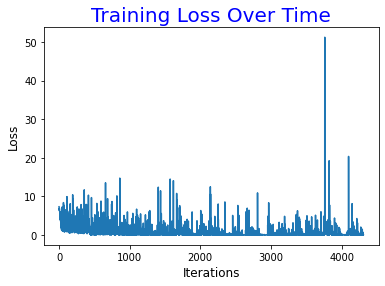

In [15]:
efficientnet = models.efficientnet_b7(pretrained=True)
num_flatten = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Linear(num_flatten, 2)
model = efficientnet.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, optimizer, epochs=10)

In [ ]:
efficientnet.classifier

## Save Model

In [16]:
torch.save(model.state_dict(), 'nsfw_efficientb7.pt')

## Load Model for Evaluating or Testing

In [ ]:

model_efficientb7 = efficientnet
model_efficientb7.load_state_dict(torch.load('nsfw_efficientb7.pt'))  